# Senzing + Neo4j: Build a knowledge graph

## Set up the Python environment

First, we need to import the Python library dependencies which are required for the code we'll be running.

In [1]:
from dataclasses import dataclass, field
import json
import os
import pathlib
import sys
import typing

from graphdatascience import GraphDataScience 
from icecream import ic
from tqdm import tqdm
import dotenv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import watermark

%load_ext watermark

Show a "watermark" of which versions are being used for system componenents and library dependencies. This may help in case you need to troubleshoot the dependencies on your system, e.g., if there's some conflict during installation.

In [2]:
%watermark
%watermark --iversions

Last updated: 2024-03-27T19:34:58.958725-07:00

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.22.2

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.8.3
sys       : 3.11.0 (v3.11.0:deaf509e8f, Oct 24 2022, 14:43:23) [Clang 13.0.0 (clang-1300.0.29.30)]
seaborn   : 0.13.2
pandas    : 2.2.1
json      : 2.0.9
watermark : 2.4.3



## Parse the results from Senzing

Let's define a `dataclass` to represent the parsed results from Senzing entity resolution.

In [3]:
@dataclass(order=False, frozen=False)
class Entity:  # pylint: disable=R0902
    """
A data class representing a resolved entity.
    """
    entity_id: id
    num_recs: int
    records: typing.Set[ str ] = field(default_factory = lambda: set([]))
    related: typing.Dict[ int, dict ] = field(default_factory = lambda: {})
    has_ref: bool = False

Parse the JSON data from the export, to build a dictionary of entities indexed by their unique identifiers. Also keep track of both the "resolved" and "related" records for each entity, to use for constructing the knowledge graph from these results.

In [4]:
export_path: pathlib.Path = pathlib.Path("export.json")
entities: dict = {}

with export_path.open() as fp:
    for line in tqdm(fp.readlines(), desc = "read JSON"):
        entity_dat: dict = json.loads(line)
        entity_id: int = entity_dat["RESOLVED_ENTITY"]["ENTITY_ID"]

        records: set = set([
            ".".join([ r["DATA_SOURCE"], r["RECORD_ID"] ]).upper()
            for r in entity_dat["RESOLVED_ENTITY"]["RECORDS"]
        ])

        entities[entity_id] = Entity(
            entity_id = entity_id,
            records = records,
            num_recs = len(records),
            related = {
                r["ENTITY_ID"]: r
                for r in entity_dat["RELATED_ENTITIES"]
            },
        )

read JSON: 100%|████████████████████████████████████████████████████████████████████████████████████| 99156/99156 [00:03<00:00, 32949.26it/s]


Let's examine one of the resolved entity objects, to see which fields are available

In [6]:
entity_dat

{'RESOLVED_ENTITY': {'ENTITY_ID': 438737,
  'RECORDS': [{'DATA_SOURCE': 'SAFEGRAPH',
    'RECORD_ID': 'zzw-222@5yv-c8t-t7q',
    'ENTITY_TYPE': 'GENERIC',
    'INTERNAL_ID': 438737,
    'ENTITY_KEY': '7A2952039A2EDAE86C89FF025284618BB47F5B0E',
    'ENTITY_DESC': 'Royalty Renee Salez',
    'MATCH_KEY': '',
    'MATCH_LEVEL': 0,
    'MATCH_LEVEL_CODE': '',
    'ERRULE_CODE': '',
    'LAST_SEEN_DT': '2024-03-12 18:54:15.638'}]},
 'RELATED_ENTITIES': []}

## Connect the GDS library to Neo4j Desktop

Install:

  * <https://github.com/neo4j/graph-data-science-client>
  * <https://neo4j.com/docs/graph-data-science/current/>
  * <https://neo4j.com/docs/graph-data-science/current/installation/neo4j-desktop/>

Set up a GDS connection using our credentials for Neo4j Desktop

In [3]:
dotenv.load_dotenv(dotenv.find_dotenv())

bolt_uri: str = os.environ.get("NEO4J_BOLT")
username: str = os.environ.get("NEO4J_USER")
password: str = os.environ.get("NEO4J_PASS")

gds:GraphDataScience = GraphDataScience(
    bolt_uri,
    auth = ( username, password, ),
    aura_ds = False,
)

## Connect the KG in Neo4j

Delete the previous graph data...

In [22]:
with driver.session() as session:
    #session.run("MATCH (x) DETACH DELETE x")
    #session.run("DROP CONSTRAINT unique_record")
    #session.run("DROP CONSTRAINT unique_entity")
    pass

In [23]:
with driver.session() as session:
    query: str = """
CREATE CONSTRAINT unique_record 
    IF NOT EXISTS FOR (rec:Record) 
    REQUIRE rec.uid IS UNIQUE
    """
    
    session.run(query)

    query = """
CREATE CONSTRAINT unique_entity 
    IF NOT EXISTS FOR (ent:Entity) 
    REQUIRE ent.uid IS UNIQUE
    """
    
    session.run(query)

### Populate nodes from the dataset records

Define utility functions used for loading the graph data.

In [24]:
def get_property_keys (
    df: pd.DataFrame,
    ) -> typing.List[ str ]:
    """
Convert the column names from the given Pandas dataframe into Cypher property names.
    """
    return [
        name.lower().replace(" ", "_")
        for name in df.columns.values.tolist()
    ]


def safe_value (
    obj: typing.Any,
    ) -> typing.Any:
    """
Escape double quotes within string values.
    """
    if isinstance(obj, str):
        return obj.replace('"', "'")

    return obj

In [25]:
def format_merge_record (
    keys: typing.List[ str ],
    vals: list,
    ) -> str:
    """
Format one MERGE statement in Cypher for the values of a given Record.
    """
    safe_vals = [ safe_value(v) for v in vals ]
    row_dict: dict = dict(zip(keys, safe_vals))

    uid: str = row_dict["data_source"].upper() + "." + row_dict["record_id"]
    
    props: str = ", ".join([
        f"rec.{key} = \"{val}\""
        for key, val in row_dict.items()
    ])

    return f"""
MERGE (rec:Record {{ uid: \"{uid}\" }})
  ON CREATE
    SET {props}      
RETURN rec.data_source, rec.record_id
    """


def load_records (
    session: neo4j.Session,
    df: pd.DataFrame,
    ) -> None:
    """
Iterate over each Record from one dataset to load using Cypher.
    """
    keys: typing.List[ str ] = get_property_keys(df)

    for _, row in tqdm(df.iterrows(), desc = "merge nodes for records"):
        query: str = format_merge_record(keys, row.tolist())
        session.run(query)

### Populate nodes from the Senzing entities

In [39]:
query = """
MERGE (ent:Entity {uid: $params.uid, has_ref: $params.has_ref})
"""

with driver.session() as session:
    for entity in tqdm(entities.values(), desc = "merge nodes for entities"):
        params = {
            "uid": entity.entity_id,
            "has_ref": entity.has_ref,
        }

        session.run(
            query,
            params = params,
        )

merge nodes for entities: 100%|████████████████████████████████████████████████████████████████████████| 99156/99156 [46:34<00:00, 35.48it/s]


In [31]:
entity = list(entities.values())[0]
ic(entity);

ic| entity: Entity(entity_id=1,
                   num_recs=3,
                   records={'DOL_WHISARD.7874', 'DOL_WHISARD.7631', 'DOL_WHISARD.7789'},
                   related={113: {'ENTITY_ID': 113,
                                  'ERRULE_CODE': 'CNAME',
                                  'IS_AMBIGUOUS': 0,
                                  'IS_DISCLOSED': 0,
                                  'MATCH_KEY': '+NAME',
                                  'MATCH_LEVEL': 2,
                                  'MATCH_LEVEL_CODE': 'POSSIBLY_SAME',
                                  'RECORDS': [{'DATA_SOURCE': 'DOL_WHISARD',
                                               'RECORD_ID': '8898'},
                                              {'DATA_SOURCE': 'DOL_WHISARD',
                                               'RECORD_ID': '8903'},
                                              {'DATA_SOURCE': 'DOL_WHISARD',
                                               'RECORD_ID': '8128'},
               

### Connect the resolved records and related entities

In [49]:
query = """
MATCH
    (ent:Entity {uid: $params.entity_uid}),
    (rec:Record {uid: $params.record_uid})       
MERGE (ent)-[:RESOLVES]->(rec)
"""

with driver.session() as session:
    for entity in tqdm(entities.values(), desc = "merge entity->record"):
        for record_uid in entity.records:
            params = {
                "entity_uid": entity.entity_id,
                "record_uid": record_uid,
            }

            session.run(
                query,
                params = params,
            )

merge entity->record: 100%|███████████████████████████████████████████████████████████████████████████| 99156/99156 [03:55<00:00, 421.28it/s]


In [14]:
query = """
MATCH
    (ent:Entity {uid: $params.entity_uid}),
    (rel_ent:Entity {uid: $params.rel_ent})       
MERGE (ent)-[:RELATED {ambiguous: $params.ambiguous, disclosed: $params.disclosed, match_key: $params.match_key, match_level: $params.match_level, match_level_code: $params.match_level_code}]->(rel_ent)
"""

with driver.session() as session:
    for entity in tqdm(entities.values(), desc = "merge entity->related"):
        for rel_key, rel_ent in entity.related.items():
            params = {
                "entity_uid": entity.entity_id,
                "rel_ent": rel_ent["ENTITY_ID"],
                "ambiguous": (rel_ent["IS_AMBIGUOUS"] == 0),
                "disclosed": (rel_ent["IS_DISCLOSED"] == 0),
                "match_key": rel_ent["MATCH_KEY"],
                "match_level": rel_ent["MATCH_LEVEL"],
                "match_level_code": rel_ent["MATCH_LEVEL_CODE"],
            }

            session.run(
                query,
                params = params,
            )

merge entity->related: 100%|█████████████████████████████████████████████████████████████████████████| 99156/99156 [2:18:18<00:00, 11.95it/s]


In [24]:
with driver.session() as session:
    query = """
MATCH (ent:Entity)
RETURN
    ent.uid, COUNT { (ent)-[:RESOLVES]->(:Record) } AS num_recs
ORDER BY num_recs DESC
LIMIT 20
    """
    
    for ent in session.run(query):
        ic(ent)

ic| ent: <Record ent.uid=121 num_recs=15>
ic| ent: <Record ent.uid=137 num_recs=11>
ic| ent: <Record ent.uid=509 num_recs=10>
ic| ent: <Record ent.uid=17 num_recs=8>
ic| ent: <Record ent.uid=65 num_recs=7>
ic| ent: <Record ent.uid=113 num_recs=7>
ic| ent: <Record ent.uid=3 num_recs=6>
ic| ent: <Record ent.uid=41 num_recs=6>
ic| ent: <Record ent.uid=225 num_recs=6>
ic| ent: <Record ent.uid=146 num_recs=6>
ic| ent: <Record ent.uid=151 num_recs=5>
ic| ent: <Record ent.uid=383 num_recs=5>
ic| ent: <Record ent.uid=374 num_recs=5>
ic| ent: <Record ent.uid=433 num_recs=4>
ic| ent: <Record ent.uid=368 num_recs=4>
ic| ent: <Record ent.uid=239 num_recs=4>
ic| ent: <Record ent.uid=105 num_recs=4>
ic| ent: <Record ent.uid=286 num_recs=4>
ic| ent: <Record ent.uid=134 num_recs=4>
ic| ent: <Record ent.uid=355 num_recs=4>


## Analyze the impact of ER

Now let's analyze the Senzing results, measuring how much the process of _entity resolution_ has consolidated records among the input datasets.

In [7]:
for entity in entities.values():
    if entity.num_recs > 1:
        entity.has_ref = True

        for inf_ent in entity.related.keys():
            entities[inf_ent].has_ref = True

has_ref_ents: int = len([
    e for e in entities.values()
    if e.has_ref
])

In particular, it's helpful for planning about our eventual knowledge graph to understand the:

  - total number of entities
  - number of entities which have references (i.e., these will be linked within the knowledge graph)

In [8]:
ic(len(entities))
ic(has_ref_ents);

ic| len(entities): 99156
ic| has_ref_ents: 14063


Now visualize this as a histogram of the resolved entities versus their related records in the input datasets.

From this analysis, more than 14K entities were linked to records through _entity resolution_.
These can be used to construct _nodes_, _properties_, and _relations_ in a knowledge graph.

In [10]:
num_rel_2: int = 3437
has_ref_ents - num_rel_2

10626

Of the linked entities, more than 10K have three or more records linked.
This is interesting since we're trying to link records across three datasets.
We'll get more specific stats later through Cypher graph queries in Neo4j.

In [4]:
df = gds.run_cypher(
  """
MATCH (ent:Entity)
RETURN COUNT(ent.uid) as count_ent, COUNT { (ent)-[:RELATED]->(:Entity) } as num_rel
ORDER BY num_rel DESC
  """
)

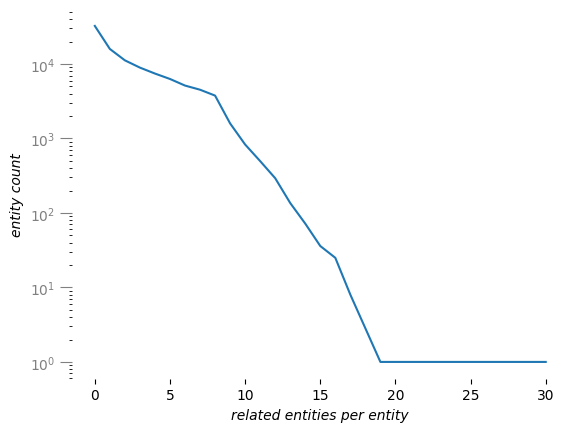

In [5]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "sans-serif"

y = sns.lineplot(df, y = "count_ent", x = "num_rel")
y.tick_params(axis = "y", size = 9, colors = "gray")

plt.xlabel("related entities per entity", size = 10, fontstyle = "italic")
plt.ylabel("entity count", size = 10, fontstyle = "italic")

sns.despine(bottom = True, left = True)
plt.yscale("log")

In [6]:
df = gds.run_cypher(
  """
MATCH (ent:Entity)
RETURN COUNT(ent.uid) as count_ent, COUNT { (ent)-[:RESOLVES]->(:Record) } as num_rec
ORDER BY num_rec DESC
  """
)

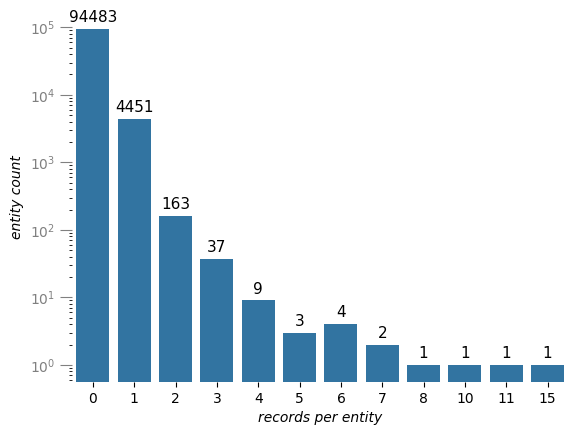

In [7]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "sans-serif"

y = sns.barplot(df, y = "count_ent", x = "num_rec")
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "black", fontsize = 11)

plt.xlabel("records per entity", size = 10, fontstyle = "italic")
plt.ylabel("entity count", size = 10, fontstyle = "italic")

sns.despine(bottom = True, left = True)
plt.yscale("log")